In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
data = Path("../data")
plot_path = data / "plots"
map_path = data / "graph3_map"
stat_path = map_path / "stats"

# Users dataset

In [9]:
users = pd.read_csv(map_path / "users_country_aff.csv")

# 0. Number of users per country

In [10]:
# remove users who are located in Japan
users = users[users["country"] != "Japan"]
print("Number of unique non-Japanese users: {:,}".format(users["user_id"].nunique()))

Number of unique non-Japanese users: 133,795


In [11]:
# For each "country, country_aff" pair, count the number of users
country_num_users = (
    users.groupby(["country", "country_aff"])
    .agg({"user_id": "nunique"})
    .reset_index()
    .rename(columns={"user_id": "num_users"})
)
country_num_users.to_csv(stat_path / "country_num_users.csv", index=False)

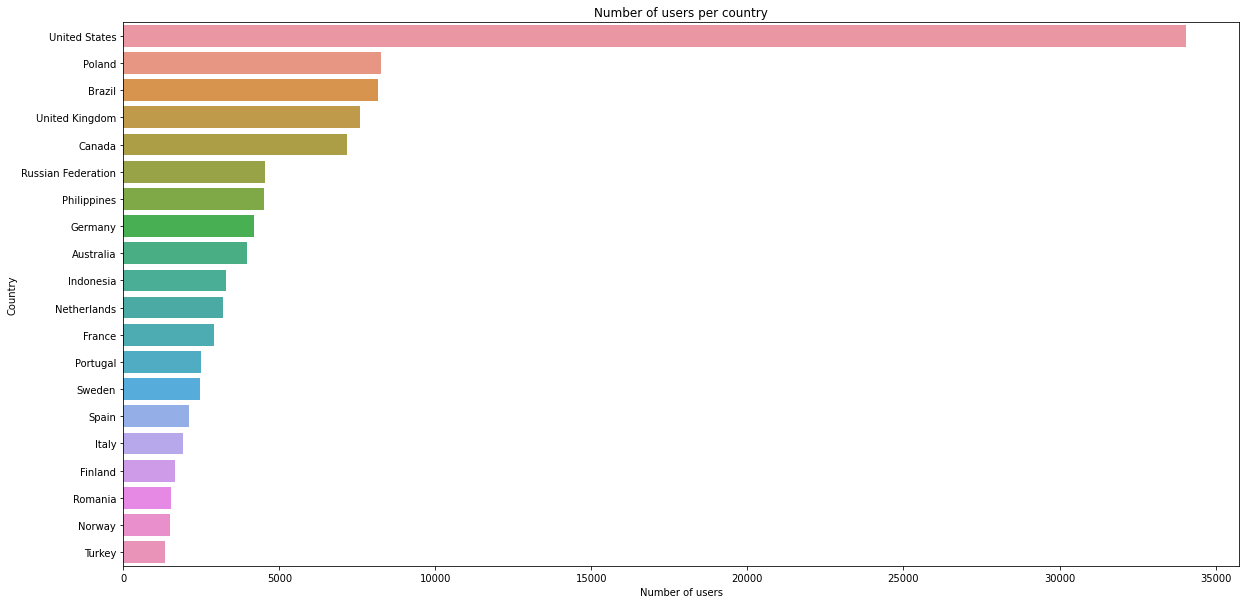

In [12]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
plot = sns.countplot(
    y="country", 
    data=users, 
    order=users["country"].value_counts()[:20].index
)

title = "Number of users per country"
plt.title(title)
plt.xlabel("Number of users")
plt.ylabel("Country")

# Set the background color to white
plot.figure.set_facecolor('white')

plt.show()

# Save the plot as a png file with white background
plot.figure.savefig(plot_path / "country_num_users.png", transparent=False)

# 1. Gender balance per country

In [13]:
# For each "country, country_aff" pair, derive the gender balance of the users
country_gender_balance = users.groupby(["country", "country_aff"])["gender"].value_counts(normalize=True).unstack().reset_index()
# Replace Nan values by 0
country_gender_balance.fillna(0, inplace=True)

country_gender_balance

gender,country,country_aff,Female,Male,Non-Binary
0,Afghanistan,Afghanistan,0.000000,1.000000,0.000000
1,Albania,Albania,0.354839,0.612903,0.032258
2,Algeria,Algeria,0.210526,0.789474,0.000000
3,Andorra,Andorra,0.333333,0.666667,0.000000
4,Angola,Angola,0.125000,0.875000,0.000000
...,...,...,...,...,...
199,Venezuela,Venezuela,0.299674,0.700326,0.000000
200,Vietnam,Vietnam,0.225806,0.766129,0.008065
201,Yemen,Yemen,0.100000,0.900000,0.000000
202,Zambia,Zambia,0.000000,1.000000,0.000000


In [14]:
import numpy as np

log3 = lambda x: np.log(x) / np.log(3)

def calculate_entropy(df, columns):
    # Calculate probabilities for each category
    total = df[columns].sum(axis=1)
    probabilities = df[columns].div(total, axis=0)
    
    # Calculate entropy for each row
    entropy = -probabilities.apply(lambda x: np.nansum(x * log3(x)), axis=1)
    
    # Create new dataframe with "entropy" column
    result = df.copy()
    result['entropy'] = entropy
    
    return result

country_gender_balance = calculate_entropy(country_gender_balance, ['Female', 'Male', 'Non-Binary'])
country_gender_balance.sort_values(by="entropy", ascending=False, inplace=True)
country_gender_balance.to_csv(stat_path / "country_gender_balance.csv", index=False)

country_gender_balance

/home/julien/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


gender,country,country_aff,Female,Male,Non-Binary,entropy
158,Saint Vincent and the Grenadines,Saint Vincent and the Grenadines,0.333333,0.333333,0.333333,1.000000
32,Burkina Faso,Burkina Faso,0.250000,0.500000,0.250000,0.946395
197,Uzbekistan,Uzbekistan,0.400000,0.500000,0.100000,0.858673
1,Albania,Albania,0.354839,0.612903,0.032258,0.708589
30,Brunei Darussalam,Brunei Darussalam,0.360000,0.620000,0.020000,0.675777
...,...,...,...,...,...,...
138,Null Island,Null Island,0.000000,1.000000,0.000000,-0.000000
147,Pitcairn,United Kingdom,0.000000,1.000000,0.000000,-0.000000
157,Saint Pierre and Miquelon,France,0.000000,1.000000,0.000000,-0.000000
159,Samoa,Samoa,1.000000,0.000000,0.000000,-0.000000


In [15]:
merge = pd.merge(country_num_users, country_gender_balance, on=["country", "country_aff"])
merge.sort_values(by="entropy", ascending=False)

,country,country_aff,num_users,Female,Male,Non-Binary,entropy
158,Saint Vincent and the Grenadines,Saint Vincent and the Grenadines,3,0.333333,0.333333,0.333333,1.000000
32,Burkina Faso,Burkina Faso,4,0.250000,0.500000,0.250000,0.946395
197,Uzbekistan,Uzbekistan,10,0.400000,0.500000,0.100000,0.858673
1,Albania,Albania,32,0.354839,0.612903,0.032258,0.708589
30,Brunei Darussalam,Brunei Darussalam,51,0.360000,0.620000,0.020000,0.675777
...,...,...,...,...,...,...,...
138,Null Island,Null Island,1,0.000000,1.000000,0.000000,-0.000000
147,Pitcairn,United Kingdom,2,0.000000,1.000000,0.000000,-0.000000
157,Saint Pierre and Miquelon,France,2,0.000000,1.000000,0.000000,-0.000000
159,Samoa,Samoa,1,1.000000,0.000000,0.000000,-0.000000


# 2. Age slices for each country

Need to load the cleaned dataset, that handled users who have an excessively large or low age

In [7]:
users["birth_date"].sort_values()

28031        1-01-01
92978     1930-01-01
17214     1930-01-01
14340     1930-01-01
132546    1930-01-01
             ...    
136014           NaN
136018           NaN
136029           NaN
136036           NaN
136043           NaN
Name: birth_date, Length: 133911, dtype: object

In [8]:
users_cleaned = pd.read_csv(data / "users_cleaned.csv")

# See the differences between the "user_id" set of users_cleaned and the "user_id" set of users
print("Number of users in users_cleaned: {:,}".format(users_cleaned["user_id"].nunique()))
print("Number of users in users: {:,}".format(users["user_id"].nunique()))
print("Number of users in users_cleaned but not in users: {:,}".format(users_cleaned[~users_cleaned["user_id"].isin(users["user_id"])]["user_id"].nunique()))
print("Number of users in users but not in users_cleaned: {:,}".format(users[~users["user_id"].isin(users_cleaned["user_id"])]["user_id"].nunique()))

Number of users in users_cleaned: 108,711
Number of users in users: 133,795
Number of users in users_cleaned but not in users: 11,357
Number of users in users but not in users_cleaned: 36,441


In [9]:
users_cleaned["birth_date"].sort_values()

108465    1969-01-10 00:00:00
9861      1969-01-11 00:00:00
71624     1969-02-08 00:00:00
16208     1969-02-14 00:00:00
22098     1969-03-05 00:00:00
                 ...         
1718      2008-09-02 00:00:00
3521      2008-09-27 00:00:00
47601     2008-09-28 00:00:00
61694     2008-12-04 00:00:00
9278      2008-12-15 00:00:00
Name: birth_date, Length: 108711, dtype: object

In [10]:
users_ages = users_cleaned.merge(users, on="user_id", how="inner")
users_ages

,username_x,user_id,user_watching_x,user_completed_x,user_onhold_x,user_dropped_x,user_plantowatch_x,user_days_spent_watching_x,gender_x,location_x,...,location_y,birth_date_y,access_rank_y,join_date_y,last_online_y,stats_mean_score_y,stats_rewatched_y,stats_episodes_y,country,country_aff
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",...,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India,India
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",...,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States,United States
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",...,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico,Mexico
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",...,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia,Malaysia
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",...,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0,Netherlands,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97426,isoann,797785,14,213,11,20,136,64.372222,Male,Poland:,...,Poland:,1997-01-13,NaN,2011-10-23,1900-04-02 13:21:00,8.03,2.0,3944.0,Poland,Poland
97427,bumcakee,1396285,13,116,5,9,22,41.365972,Female,"nhollywood, california",...,"nhollywood, california",1998-07-18,NaN,2012-07-14,2017-02-14 00:30:00,8.86,24.0,3027.0,United States,United States
97428,Scarlet95,2478991,6,103,10,8,54,46.827083,Female,Belgium,...,Belgium,1995-10-17,NaN,2013-04-24,2016-12-18 08:41:00,7.40,1.0,2906.0,Belgium,Belgium
97429,Torasori,3975907,22,239,0,4,176,72.361111,Male,"Latvia, Riga",...,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia,Latvia


In [11]:
users_ages["birth_date_x"].sort_values()

97211    1969-01-10 00:00:00
8808     1969-01-11 00:00:00
1066     1969-03-05 00:00:00
10583    1969-03-14 00:00:00
75087    1969-03-20 00:00:00
                ...         
23925    2008-07-16 00:00:00
84475    2008-07-18 00:00:00
3143     2008-09-27 00:00:00
55142    2008-12-04 00:00:00
8285     2008-12-15 00:00:00
Name: birth_date_x, Length: 97431, dtype: object

In [12]:
users_ages = users_ages[["user_id", "birth_date_x", "country", "country_aff"]]
users_ages.rename(columns={"birth_date_x": "birth_date"}, inplace=True)
# Convert birth_date to the year
users_ages["birth_date"] = pd.to_datetime(users_ages["birth_date"])
users_ages["birth_year"] = users_ages["birth_date"].dt.year

print("Min birth_year: {}".format(users_ages["birth_year"].min()))
print("Max birth_year: {}".format(users_ages["birth_year"].max()))

users_ages

Min birth_year: 1969
Max birth_year: 2008


/tmp/ipykernel_34165/71965479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_ages.rename(columns={"birth_date_x": "birth_date"}, inplace=True)
/tmp/ipykernel_34165/71965479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_ages["birth_date"] = pd.to_datetime(users_ages["birth_date"])
/tmp/ipykernel_34165/71965479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,user_id,birth_date,country,country_aff,birth_year
0,2255153,1990-04-29,India,India,1990
1,37326,1991-08-01,United States,United States,1991
2,228342,1990-12-14,Mexico,Mexico,1990
3,327311,1998-08-24,Malaysia,Malaysia,1998
4,5015094,1999-10-24,Netherlands,Netherlands,1999
...,...,...,...,...,...
97426,797785,1997-01-13,Poland,Poland,1997
97427,1396285,1998-07-18,United States,United States,1998
97428,2478991,1995-10-17,Belgium,Belgium,1995
97429,3975907,1998-11-18,Latvia,Latvia,1998


In [13]:
# Group users by country, and in each country group by birth year
country_users_ages = users_ages.groupby(["country", "country_aff", "birth_year"]).agg({"user_id": "nunique"})
country_users_ages = country_users_ages.rename(columns={"user_id": "num_users"})
country_users_ages

num_users
country  country_aff birth_year           
Albania  Albania     1989                1
                     1991                1
                     1992                5
                     1993                5
                     1994                2
...                                    ...
Yemen    Yemen       2000                1
Zimbabwe Zimbabwe    1991                1
                     1992                1
                     1993                1
                     1997                2

[2728 rows x 1 columns]

In [14]:
country_users_ages.to_csv(stat_path / "country_users_ages.csv")

In [15]:
country_users_ages.loc[["United States", "United States"]]

num_users
country       country_aff   birth_year           
United States United States 1969               23
                            1970               15
                            1971               19
                            1972               20
                            1973               34
...                                           ...
                            2003               60
                            2004               29
                            2005                5
                            2006                5
                            2007                2

[78 rows x 1 columns]

<Figure size 1440x720 with 0 Axes>

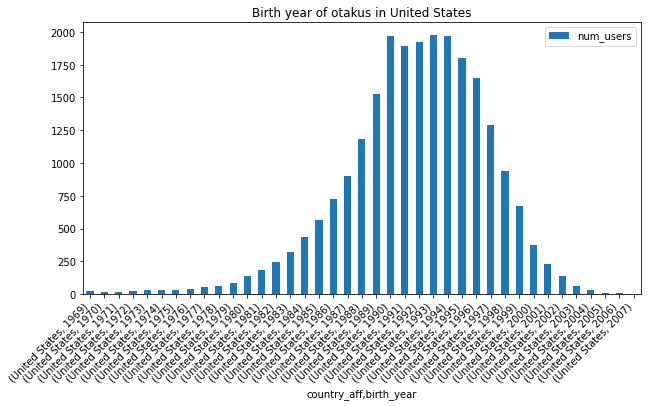

In [16]:
country = "United States"

plt.figure(figsize=(20, 10))
# age_slices.loc[name, :].plot(kind="bar", figsize=(10, 5))

# The previous line does not work anymore, as we have now country and country_aff as index
country_users_ages.loc[country].plot(kind="bar", figsize=(10, 5))

# Display angled xticks
plt.xticks(rotation=45, ha="right")

plt.title("Birth year of otakus in {}".format(country))
plt.show()

# 3. Average number of days spent watching per country

## Countries where the users watched the highest number of animes

In [17]:
# group users by country and calculate the average "user_days_spent_watching"
users["user_days_spent_watching"] = users["user_days_spent_watching"].astype(float)
users.groupby("country")["user_days_spent_watching"].mean().sort_values(ascending=False)

country
Argentina                   2837.089936
Solomon Islands              224.930000
Burkina Faso                 213.437500
China                        179.864582
Mozambique                   169.985000
                               ...     
Togo                           8.010000
Anguilla                       4.550000
Marshall Islands               3.670000
Turks and Caicos Islands       0.000000
Senegal                        0.000000
Name: user_days_spent_watching, Length: 204, dtype: float64

Suspicious values: let's look at the cleaned dataset

## Users cleaned dataset

In [18]:
# Merge but without adding the suffixes
users_days = users_cleaned.merge(users, on="user_id", how="inner")
print("Number of users who have a well-defined number of days spent watching: {:,}".format(users_ages["user_id"].nunique()))
users_days

Number of users who have a well-defined number of days spent watching: 97,354


,username_x,user_id,user_watching_x,user_completed_x,user_onhold_x,user_dropped_x,user_plantowatch_x,user_days_spent_watching_x,gender_x,location_x,...,location_y,birth_date_y,access_rank_y,join_date_y,last_online_y,stats_mean_score_y,stats_rewatched_y,stats_episodes_y,country,country_aff
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",...,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India,India
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",...,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States,United States
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",...,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico,Mexico
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",...,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia,Malaysia
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",...,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0,Netherlands,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97426,isoann,797785,14,213,11,20,136,64.372222,Male,Poland:,...,Poland:,1997-01-13,NaN,2011-10-23,1900-04-02 13:21:00,8.03,2.0,3944.0,Poland,Poland
97427,bumcakee,1396285,13,116,5,9,22,41.365972,Female,"nhollywood, california",...,"nhollywood, california",1998-07-18,NaN,2012-07-14,2017-02-14 00:30:00,8.86,24.0,3027.0,United States,United States
97428,Scarlet95,2478991,6,103,10,8,54,46.827083,Female,Belgium,...,Belgium,1995-10-17,NaN,2013-04-24,2016-12-18 08:41:00,7.40,1.0,2906.0,Belgium,Belgium
97429,Torasori,3975907,22,239,0,4,176,72.361111,Male,"Latvia, Riga",...,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia,Latvia


In [19]:
users_days = users_days[["user_id", "user_days_spent_watching_x", "country", "country_aff"]]
users_days = users_days.rename(columns={"user_days_spent_watching_x": "user_days_spent_watching"})
print(users_days["user_days_spent_watching"].describe())
users_days

count    97431.000000
mean        61.935728
std         58.702099
min          0.500694
25%         21.334375
50%         46.404861
75%         84.408333
max        945.683333
Name: user_days_spent_watching, dtype: float64


,user_id,user_days_spent_watching,country,country_aff
0,2255153,55.091667,India,India
1,37326,82.574306,United States,United States
2,228342,159.483333,Mexico,Mexico
3,327311,11.394444,Malaysia,Malaysia
4,5015094,30.458333,Netherlands,Netherlands
...,...,...,...,...
97426,797785,64.372222,Poland,Poland
97427,1396285,41.365972,United States,United States
97428,2478991,46.827083,Belgium,Belgium
97429,3975907,72.361111,Latvia,Latvia


In [20]:
country_num_days_spent_watching_mean = (
    users_days.groupby(["country", "country_aff"])
    .agg({"user_id": "nunique", "user_days_spent_watching": "mean"})
    .sort_values(by="user_days_spent_watching", ascending=False)
)
country_num_days_spent_watching_mean.columns = ["num_users", "num_days_spent_watching_mean"]
country_num_days_spent_watching_mean.to_csv(stat_path / "country_num_days_spent_watching_mean.csv")
country_num_days_spent_watching_mean

,,num_users,num_days_spent_watching_mean
country,country_aff,,
Solomon Islands,Solomon Islands,1,216.353472
Cameroon,Cameroon,1,186.013426
Chad,Chad,1,182.938889
New Caledonia,France,1,176.944444
Réunion,France,4,176.478582
...,...,...,...
Ghana,Ghana,2,9.103472
Papua New Guinea,Papua New Guinea,3,8.046065
Togo,Togo,1,8.018750


We observe that:
- Argentina is no longer top 1
- A lot of countries have seen their mean decrease
- The countries with mean 0 have been removed 

count    193.000000
mean      66.726980
std       32.308234
min        0.977083
25%       51.989294
50%       63.783953
75%       74.100705
max      216.353472
Name: num_days_spent_watching_mean, dtype: float64


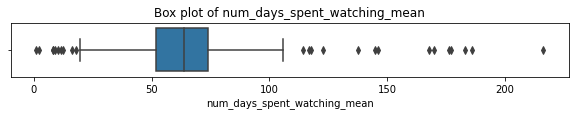

In [21]:
print(country_num_days_spent_watching_mean["num_days_spent_watching_mean"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(x="num_days_spent_watching_mean", data=country_num_days_spent_watching_mean)
title = "Box plot of num_days_spent_watching_mean"
plt.title(title)
plt.xlabel("num_days_spent_watching_mean")
plt.show()

Hmm, lots of outliers, even in the cleaned version. Let's look at the corresponding countries

In [22]:
country_num_days_spent_watching_mean.sort_values(by="num_days_spent_watching_mean", ascending=False)[:20]

,,num_users,num_days_spent_watching_mean
country,country_aff,,
Solomon Islands,Solomon Islands,1,216.353472
Cameroon,Cameroon,1,186.013426
Chad,Chad,1,182.938889
New Caledonia,France,1,176.944444
Réunion,France,4,176.478582
Kyrgyzstan,Kyrgyzstan,1,170.054861
Pitcairn,United Kingdom,1,168.003472
US Virgin Islands,United States,2,146.014931
Mozambique,Mozambique,2,144.828235


We observe that the countries with very few users dominate the top.
Let us look only at the countries which count many users (say, more than 1000), to have more representative samples

In [23]:
country_num_days_spent_watching_mean_100 = country_num_days_spent_watching_mean[country_num_days_spent_watching_mean["num_users"] >= 100]
country_num_days_spent_watching_mean_100.sort_values(by="num_days_spent_watching_mean", ascending=False)[:20]

,,num_users,num_days_spent_watching_mean
country,country_aff,,
Morocco,Morocco,117,85.036988
Slovenia,Slovenia,107,83.211293
France,France,2183,81.415406
Saudi Arabia,Saudi Arabia,628,79.950856
Germany,Germany,2818,77.090498
Portugal,Portugal,1991,75.861763
Spain,Spain,1639,75.618321
Italy,Italy,1438,75.323243
Chile,Chile,496,75.191873


count    64.000000
mean     65.631633
std       9.012456
min      45.168334
25%      61.259466
50%      66.255038
75%      72.582716
max      85.036988
Name: num_days_spent_watching_mean, dtype: float64


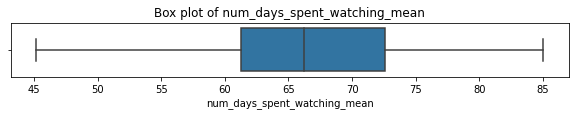

In [24]:
print(country_num_days_spent_watching_mean_100["num_days_spent_watching_mean"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(x="num_days_spent_watching_mean", data=country_num_days_spent_watching_mean_100)
title = "Box plot of num_days_spent_watching_mean"
plt.title(title)
plt.xlabel("num_days_spent_watching_mean")
plt.show()

We observe that the distribution is between 60 and 70 hours. Do people watch the same animes around the world?

In [25]:
users_cleaned.sort_values(by="user_days_spent_watching", ascending=False)

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
25195,Kanade-chan,27699,25,4665,54,0,388,952.654595,Female,"Miyazaki (宮崎), Japan",1986-01-02 00:00:00,NaN,2007-12-25 00:00:00,2013-09-13 06:31:00,6.15,22.0,58658
8199,dumnorix98,4290713,5,5479,0,66,68,945.683333,Male,"Lloret de Mar, Spain",1998-05-19 00:00:00,NaN,2014-11-30 00:00:00,2018-01-31 07:35:40,0.00,259.0,62347
25382,edinaa,6825,3,3997,20,3,224,916.217083,Female,"Brasov, Romania",1980-09-13 00:00:00,NaN,2007-07-04 00:00:00,2018-05-07 06:51:04,6.86,1.0,58102
54489,MikeOne,330583,69,3793,1,2,308,879.438160,Male,Poland,1979-12-15 00:00:00,NaN,2010-05-19 00:00:00,2018-05-20 02:21:17,6.18,21.0,56431
52913,Shouichirou,123582,101,3931,0,0,71,854.792060,Male,"Calgary, AB, Canada",1991-01-05 00:00:00,NaN,2008-12-14 00:00:00,2018-05-16 04:07:03,7.38,160.0,57313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90431,lokokinho,3739031,0,6,0,0,0,0.501389,Male,"Bojonggede, Bogor",1989-12-01 00:00:00,NaN,2014-04-29 00:00:00,2016-09-15 04:44:00,7.83,0.0,51
34009,Jessica_Yamamori,194518,1,1,0,0,0,0.501389,Female,that place over there,1994-01-31 00:00:00,NaN,2009-06-15 00:00:00,2009-06-16 11:57:00,9.50,0.0,29
57938,So_Catholic,158317,1,1,0,0,4,0.501389,Male,Apex NC.,1993-02-22 00:00:00,NaN,2009-03-11 00:00:00,2013-12-30 09:47:00,8.00,0.0,32
61000,Me77111,158327,2,1,0,0,0,0.501389,Male,"Washougal, Washington",1991-09-04 00:00:00,NaN,2009-03-11 00:00:00,2009-07-08 21:25:00,7.67,1.0,29


In [26]:
users_days.sort_values(by="user_days_spent_watching", ascending=False)

,user_id,user_days_spent_watching,country,country_aff
7331,4290713,945.683333,Spain,Spain
22701,6825,916.217083,Romania,Romania
48634,330583,879.438160,Poland,Poland
47244,123582,854.792060,Canada,Canada
62677,5585853,815.483102,Argentina,Argentina
...,...,...,...,...
55137,407621,0.502778,United States,United States
51717,158317,0.501389,United States,United States
54511,158327,0.501389,United States,United States
80909,3739031,0.501389,Indonesia,Indonesia


## Country affiliation: United Kingdom, France, Spain, Netherlands, etc.

In [27]:
country_aff_num_days_spent_watching_mean = (
    users_days.groupby(["country_aff"])
    .agg({"user_id": "nunique", "user_days_spent_watching": "mean"})
    .sort_values(by="user_days_spent_watching", ascending=False)
)
country_aff_num_days_spent_watching_mean.columns = ["num_users", "num_days_spent_watching_mean"]
# country_aff_num_days_spent_watching_mean.to_csv(stat_path / "country_aff_num_days_spent_watching_mean.csv")
country_aff_num_days_spent_watching_mean

,num_users,num_days_spent_watching_mean
country_aff,,
Solomon Islands,1,216.353472
Cameroon,1,186.013426
Chad,1,182.938889
Kyrgyzstan,1,170.054861
Mozambique,2,144.828235
...,...,...
Mauritania,1,12.575000
Ghana,2,9.103472
Papua New Guinea,3,8.046065


Let us look again only at the countries which have more than 100 users

In [28]:
country_aff_num_days_spent_watching_mean_100 = country_aff_num_days_spent_watching_mean[country_aff_num_days_spent_watching_mean["num_users"] >= 100]
country_aff_num_days_spent_watching_mean_100.sort_values(by="num_days_spent_watching_mean", ascending=False)[:20]

,num_users,num_days_spent_watching_mean
country_aff,,
Morocco,117,85.036988
Slovenia,107,83.211293
France,2194,81.660929
Saudi Arabia,628,79.950856
Germany,2818,77.090498
Portugal,1991,75.861763
Spain,1675,75.744981
Italy,1438,75.323243
Chile,496,75.191873


France increases, Spain increases